## Семинар 10: "Генерация текстов"

ФИО: Елохов Артур Владимирович

In [1]:
import numpy as np
import re
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import sys
import progressbar
from operator import itemgetter
%matplotlib inline

Этот семинар посвящен чат-ботам. Вам предстоит реализовать модель, генерирующую определенные тексты. В качестве текстов можно взять сборник цитат умных людей, предсказаний и т.д. На семинаре мы используем данные https://github.com/alvations/Quotables/blob/master/author-quote.txt

При реализации задания вы можете пользоваться кодом из этого примера: <a href=https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb>Generating Shakespeare with a Character-Level RNN</a>

### Часть 1: подготовка данных

Реализуйте датасет для дальнейшего обучения (будем использовать batch size=1)

In [2]:
! head -n 2 quotes.txt

A. A. Milne	If you live to be a hundred, I want to live to be a hundred minus one day so I never have to live without you.
A. A. Milne	Promise me you'll always remember: You're braver than you believe, and stronger than you seem, and smarter than you think.


In [3]:
lines = [x.split('\t')[1].strip() for x in open('quotes.txt').readlines()]

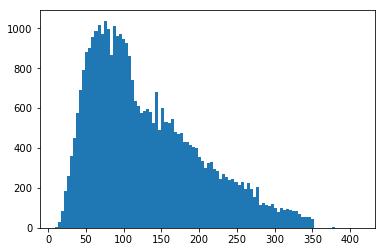

In [4]:
plt.hist(map(len, lines), bins=100);

In [5]:
line = lines[0]

In [6]:
line

'If you live to be a hundred, I want to live to be a hundred minus one day so I never have to live without you.'

In [7]:
lines = filter(lambda x: len(x) <= 50, lines)

In [8]:
class Vocabulary:
    def __init__(self, sentences):
        all_characters = set()
        for line in sentences:
            all_characters |= set(line)
        all_characters = list(all_characters)+['<eos>', '<go>']
        self.char_to_id = {x[1]:x[0] for x in enumerate(all_characters)}
        self.id_to_char = {x[0]:x[1] for x in enumerate(all_characters)}
        self.size = len(all_characters)

    def encode(self, line):
        return np.array([self.char_to_id[x] for x in line])
    
    def decode(self, tokens):
        return ''.join([self.id_to_char[x] for x in tokens])

In [9]:
vocab = Vocabulary(lines)

In [10]:
assert vocab.decode(vocab.encode(lines[0])) == lines[0]

In [11]:
class Quotes(Dataset):
    def __init__(self, sentences, vocab):
        # Construct vocabulary + EOS & GO tokens
        self.sentences = sentences
        self.vocab = vocab
        
    def __len__(self):
        return len(self.sentences)
        
    def __getitem__(self, idx):
        input = self.vocab.encode(['<go>'] + list(self.sentences[idx]))
        output = self.vocab.encode(list(self.sentences[idx])+['<eos>'])
        return input, output

In [12]:
dataset = Quotes(lines, vocab)

In [13]:
dataloader = DataLoader(dataset, shuffle=True)

### Часть 2: определение модели

In [14]:
class Oracle(nn.Module):
    def __init__(self, vocabulary_size, embedding_size=128, hidden_size=256, layers=2):
        super(Oracle, self).__init__()
        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.generator = nn.GRU(embedding_size, hidden_size, layers, batch_first=True)
        self.classifier = nn.Linear(hidden_size, vocabulary_size)
    
    def forward(self, input):
        embedding = self.embedding(input)
        h = Variable(torch.Tensor(self.layers, 1, self.hidden_size).normal_(), requires_grad=False)*0
        output, _ = self.generator(embedding, (h))
        classes = self.classifier(output[0])
        return classes
    
    def generate(self, vocab, max_len=100):
        h = Variable(torch.Tensor(self.layers, 1, self.hidden_size).normal_(), requires_grad=False)*0
        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and len(line) < max_len:
            token = torch.Tensor([[vocab.char_to_id[current_token]]]).long()
            token_id = Variable(token, volatile=True)
            embedding = self.embedding(token_id)
            output, (h) = self.generator(embedding, (h))
            classes = self.classifier(output[0])
            new_token_id = np.argmax(classes.data.numpy())
            current_token = vocab.id_to_char[new_token_id]
            line = line + current_token
        return line

In [15]:
oracle = Oracle(vocab.size, embedding_size=128, hidden_size=256, layers=2)

### Часть 3: обучение модели

In [16]:
optimizer = torch.optim.Adam(oracle.parameters(), lr=1e-3)

In [17]:
criterion = nn.CrossEntropyLoss()

In [18]:
losses = []

In [19]:
Sentences = []

In [21]:
checkpoint = torch.load('checkpoint.pth.tar')
start_epoch = checkpoint['epoch']
oracle.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])

In [22]:
for epoch in xrange(1000):
    for i, (batch, target) in enumerate(dataloader):
        batch = Variable(batch)
        target = Variable(target, requires_grad=False)[0]
        prediction = oracle(batch)
        loss = criterion(prediction, target)
        loss.backward()
        if i%16 == 0: # aka batch
            optimizer.step()
            oracle.zero_grad()
            losses.append(loss.data[0])
            if i%128 == 0:
                sentence = oracle.generate(vocab)
                Sentences.append(sentence)
                print loss.data[0], sentence
            

0.836004018784 I like to sing.<eos>
0.946615457535 I like the sign of being a long time.<eos>
1.08474647999 I like to be a lot of being book.<eos>
1.29235374928 I love to be a lot of and I love to be a long.<eos>
0.731151342392 I don't want to be a great man.<eos>
1.07786548138 I don't want to be a great death and I am.<eos>
0.639129281044 I don't want to be a lot of the world.<eos>
1.07945346832 I love the pint of a lot of and I am.<eos>
0.966384351254 I love the politics.<eos>
1.10203707218 I don't have to be a great men.<eos>
0.804849386215 I don't have to be a lot of my life.<eos>
1.00615990162 I was a super the best way out.<eos>
0.739251255989 I was a super the best piny of my life.<eos>
1.10590708256 I don't want to be a lot of compass.<eos>
1.00742065907 I love to be a lot of compass.<eos>
0.990409255028 I like the started of the heart.<eos>
1.10393130779 I don't watch reality TV.<eos>
1.07523751259 I don't want to be a real too of the world.<eos>
1.00901603699 I don't want to 

KeyboardInterrupt: 

In [263]:
def save_checkpoint(state, filename='checkpoint.pth.tar'):
    torch.save(state, filename)

In [ ]:
epoch =1
save_checkpoint({
            'epoch': epoch,
            'state_dict': oracle.state_dict(),
            'optimizer' : optimizer.state_dict(),
        })

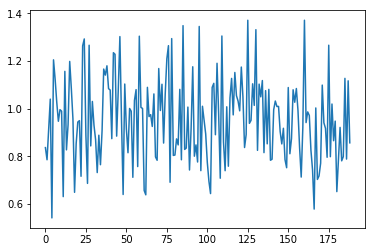

In [23]:
plt.plot(losses)

### Часть 4: оценивание модели

<i> Приведите примеры сгенерированных предложений </i>

In [24]:
import random

In [25]:
rand_smpl = [ Sentences[i] for i in sorted(random.sample(xrange(len(Sentences)), 10)) ]
for sent in rand_smpl:
    print sent

I like to sing.<eos>
I like the sign of being a long time.<eos>
I don't want to be a great man.<eos>
I don't want to be a lot of the world.<eos>
I was a super the best way out.<eos>
I don't want to be a lot of compass.<eos>
I like the started of the heart.<eos>
I don't want to be a real too of the world.<eos>
I love the stage.<eos>
I like to direct more than the soul of the world.<eos>


#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: